# Starcraft Player's Rank Prediction

## TOC:
1. [Preprocessing](#preprocessing)
    1. [Address missing/inappropriate values](#missing-values)
    2. [Address outliers](#outliers)
2. [Feature Selection](#feature-selection)
3. [Model Selection](#model-selection)
4. [Model Evaluation](#model-evaluation)
5. [Room for Improvement](#room-improvement)

In [1]:
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, recall_score

from util_functions import *

## 1. Preprocessing<a class="anchor" id="preprocessing"></a>

At first, import dataset and check the fundamental information.

In [2]:
df = pd.read_csv('./data/starcraft_player_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GameID                3395 non-null   int64  
 1   LeagueIndex           3395 non-null   int64  
 2   Age                   3395 non-null   object 
 3   HoursPerWeek          3395 non-null   object 
 4   TotalHours            3395 non-null   object 
 5   APM                   3395 non-null   float64
 6   SelectByHotkeys       3395 non-null   float64
 7   AssignToHotkeys       3395 non-null   float64
 8   UniqueHotkeys         3395 non-null   int64  
 9   MinimapAttacks        3395 non-null   float64
 10  MinimapRightClicks    3395 non-null   float64
 11  NumberOfPACs          3395 non-null   float64
 12  GapBetweenPACs        3395 non-null   float64
 13  ActionLatency         3395 non-null   float64
 14  ActionsInPAC          3395 non-null   float64
 15  TotalMapExplored     

The table above shows that 
* there is no null value in the dataset, but 
* there might be something wrong in Age, HoursPerWeek and TotalHours columns because their dtypes are object though they should be numerical values.

From here, we use train/test dataset created from original data so that test data is not affected by training process.

In [3]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42, stratify=df['LeagueIndex'], shuffle=True)
combine = [df_train, df_test]
df_train.shape, df_test.shape

((3055, 20), (340, 20))

### 1.1. Address missing/inappropriate values<a class="anchor" id="missing-values"></a>

Three columns whose dtype are object include non-numerical characters "?", as below. \
Besides, almost all "?" are included in the rows of players in the Professional leagues (LeagueIndex=8), and \
those three variables for the professional league players are all unknown, at least when it comes to the given dataset.

In [4]:
object_column = df_train.select_dtypes(include='object').columns

for column in object_column:
    nonnum_train = df_train[column].str.extract(r'([^0-9])').value_counts().rename('count_traindata')
    nonnum_test = df_test[column].str.extract(r'([^0-9])').value_counts().rename('count_testdata')
    nonnum = pd.concat([nonnum_train, nonnum_test], axis=1)
    print('# of rows including non-numerical data in "', column, '":')
    print(nonnum)
    print()

# of rows including non-numerical data in " Age ":
   count_traindata  count_testdata
0                                 
?               49               6

# of rows including non-numerical data in " HoursPerWeek ":
   count_traindata  count_testdata
0                                 
?               50               6

# of rows including non-numerical data in " TotalHours ":
   count_traindata  count_testdata
0                                 
?               51               6



In [5]:
print('Part of rows with TotalHours="?"')
df_train[(df_train['TotalHours']=='?')][['LeagueIndex', 'Age', 'HoursPerWeek', 'TotalHours']].sort_index().head(10)

Part of rows with TotalHours="?"


,LeagueIndex,Age,HoursPerWeek,TotalHours
358,5,17,20,?
1841,5,18,?,?
3340,8,?,?,?
3341,8,?,?,?
3342,8,?,?,?
3343,8,?,?,?
3344,8,?,?,?
3345,8,?,?,?
3346,8,?,?,?
3347,8,?,?,?


In [6]:
print('Count of rows for each LeagueIndex with no "?" in the Age column')
df_train[df_train['Age']!='?'].groupby('LeagueIndex').count()['Age']

Count of rows for each LeagueIndex with no "?" in the Age column


LeagueIndex
1    150
2    312
3    498
4    730
5    725
6    559
7     32
Name: Age, dtype: int64

These inappropriate data "?", are explicitly biased in rows with LeagueIndex=8, so I will drop the three columns. \
Instead, I will create a new variable "AgeMissing" which is 1 if "Age" equals "?" otherwise 0.

In [7]:
# Add a new column
for data in combine:
    data['AgeMissing'] = np.where(data['Age']=='?', 1, 0)

# Drop three columns
df_train = df_train.drop(object_column, axis=1)
df_test = df_test.drop(object_column, axis=1)

### 1.2. Address outliers<a class="anchor" id="outliers"></a>

Next, we checked if each variable had an outlier visually. \
In the boxplots below, you can see that some data points exceed the lower/highrer outlier thresholds.

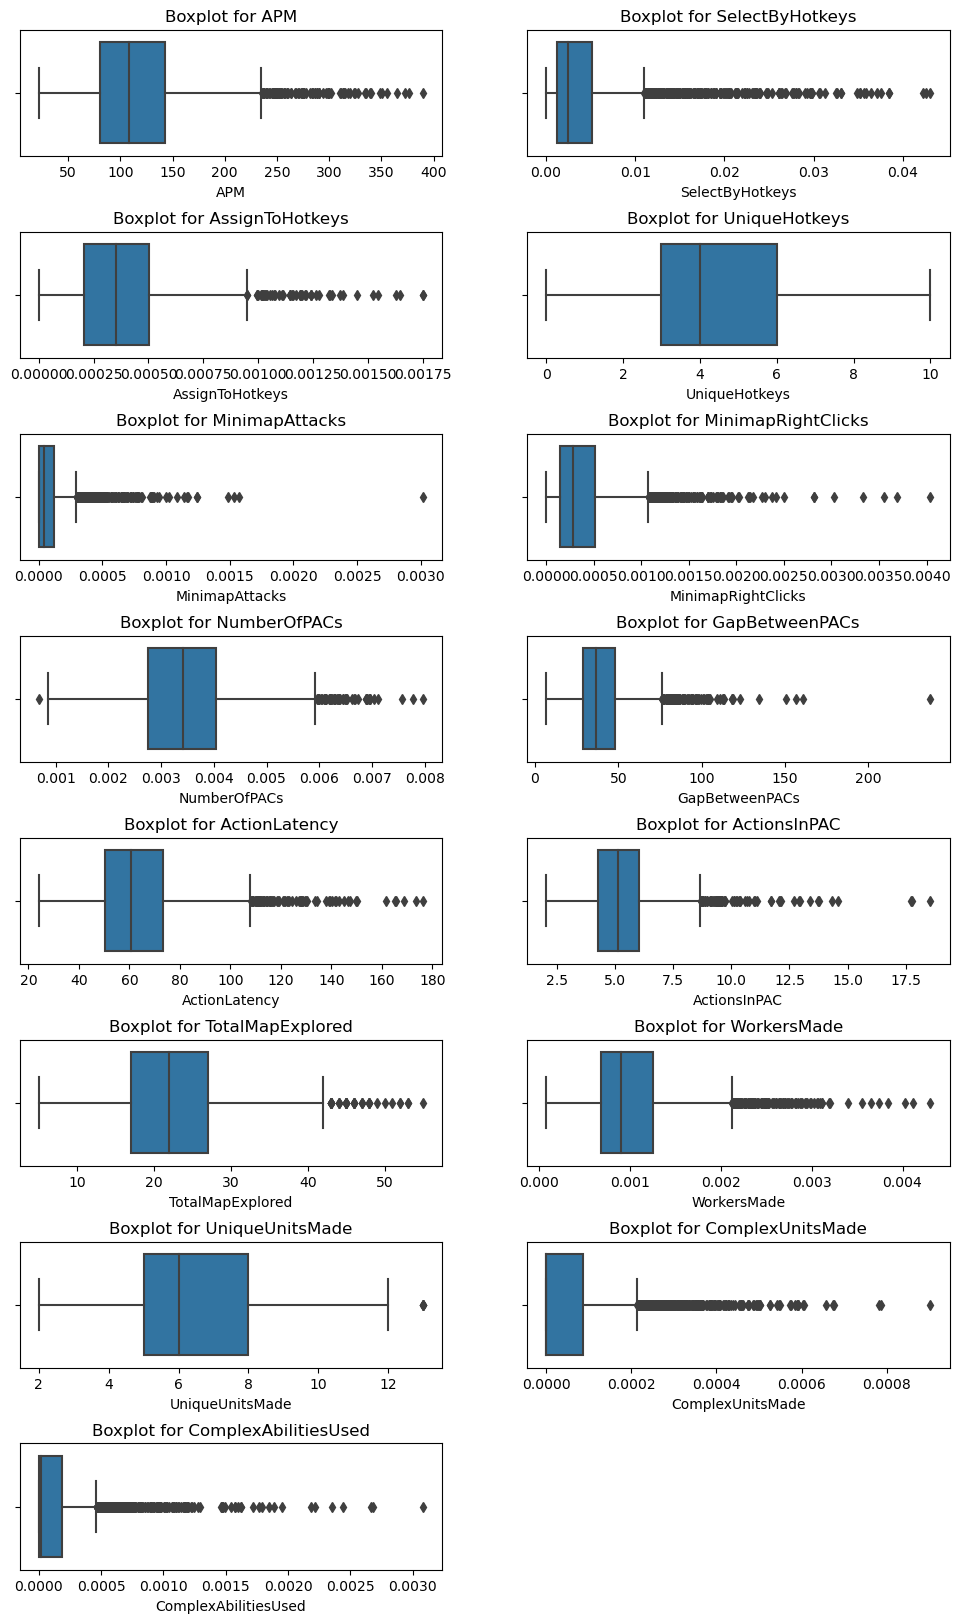

In [8]:
columns = df_train.columns[2:-1]

draw_boxplots(df_train, x=columns, vertical=False, figsize=(12, 20), hspace=0.6)

While many data points are regarded as outliers by the boxplots, I will focus only on extreme ones. \
To avoid the effect of extreme outliers, I implemented winsorization with upper limit of 0.1%, which will mitigate the outliers.

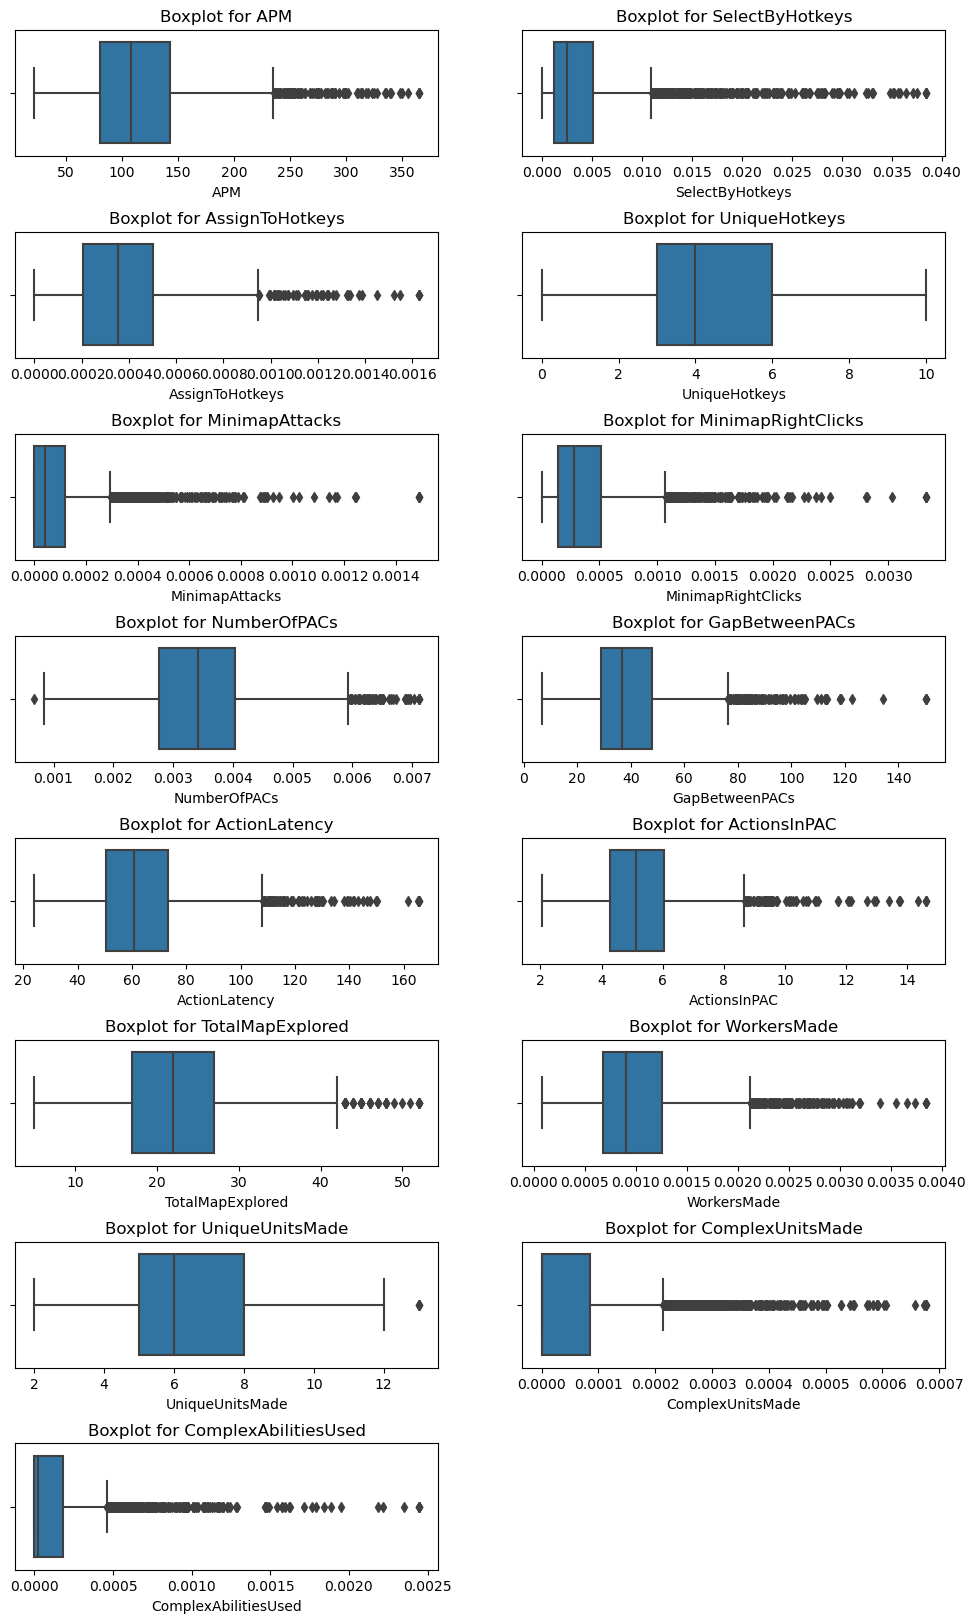

In [9]:
columns = df_train.columns[2:-1]
df_train[columns] = df_train[columns].apply(lambda x: winsorize(x, limits=[0, 0.001]))

draw_boxplots(df_train, x=columns, vertical=False, figsize=(12, 20), hspace=0.6)

## 2. Feature Selection<a class="anchor" id="feature-selection"></a>

Since we have more than 10 features in the given dataset, we should reduce the number of features to avoid some problems such as overfitting and computational efficiency. \
I drew boxplots to see the relationships between LeagueIndex and other features, and I concluded that variables which have an explicit slope of boxes should be included in a classification model.

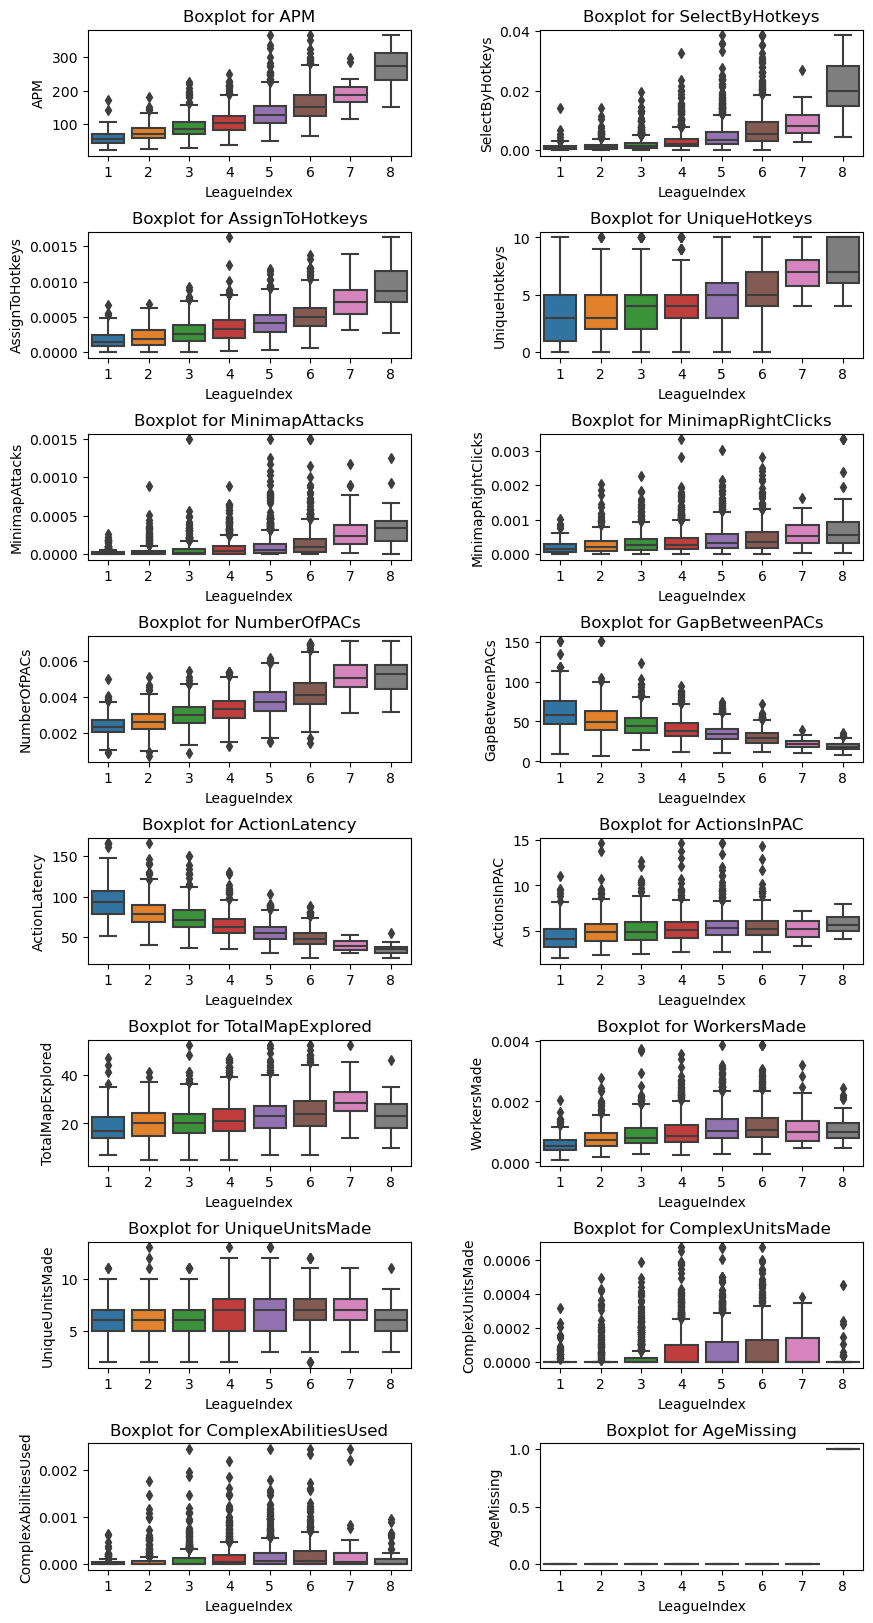

In [10]:
columns = df_train.columns[2:]

draw_boxplots(df_train, x='LeagueIndex', y=columns, vertical=True, figsize=(10, 20), hspace=0.6, wspace=0.4)

Finally, I chose 9 variables as a feature variable as below. I think the biggest factor that makes players with higer rank differ from those with lower rank is how promptly and efficiently they make actions in a game, with the help of hotkeys and minimap. All variables except for AgeMissing are related to the promptness, that is, we can expect a player to have higher rank as his/her values of those variables are larger(smaller for GapBetweenPACs and ActionLatency). \
Therefore, this feature selection seems to be reasonable.

In [11]:
features = ['APM', 'SelectByHotkeys', 'AssignToHotkeys', 'MinimapAttacks', 'MinimapRightClicks', \
            'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency', 'AgeMissing']

## 3. Model Selection<a class="anchor" id="model-selection"></a>

In order to predict player's rank, I applied Random Forest and Gradient Boosting classifier and compared their scores to select a model finally used. \
Specifically, I figured out the best hyperparameters for each classifier using GridSearchCV, and then chose a model with the best score as the best. 

In [12]:
# Assign X and y
X_train = df_train[features]
y_train = df_train['LeagueIndex']
X_test = df_test[features]
y_test = df_test['LeagueIndex']

# Search best hyperparameter/model by GridSearchCV
score_metrics = 'f1_weighted'
param_rf = {
    'n_estimators': [10, 100, 200],
    'max_depth': [3, 6, 9],
    'max_features': ['sqrt', 'log2', None]
}
param_gb = {
    'n_estimators': [10, 100, 200],
    'max_depth': [3, 6, 9],
    'max_features': ['sqrt', 'log2', None],
    'learning_rate': [0.01,0.1,1,10]
}


rf = build_classifier(RandomForestClassifier(random_state=42))
print('Random Forest:')
rf.TuneHParam(X_train, y_train, params=param_rf, cv=3, scoring=score_metrics)
print()

gb = build_classifier(GradientBoostingClassifier(random_state=42))
print('Gradient Boosting:')
gb.TuneHParam(X_train, y_train, params=param_gb, cv=3, scoring=score_metrics)
print()

Random Forest:
Best Parameters for RandomForestClassifier(random_state=42): {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 100}
Best Score RandomForestClassifier(random_state=42): 0.384

Gradient Boosting:
Best Parameters for GradientBoostingClassifier(random_state=42): {'learning_rate': 0.01, 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 200}
Best Score GradientBoostingClassifier(random_state=42): 0.381



As a result, I selected Random Forest classifier with max_depth=6, max_features='sqrt' and n_estimators=100 as the best model, though there is no big difference between those two classifiers in terms of scores.

In [13]:
best_model = rf.best_model
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features='sqrt', random_state=42)

# 4. Model Evaluation<a class="anchor" id="model-evaluation"></a>

Finally, I evaluated the constructed model using scores and confusion matrix. The facts that we can see are:
* Accuracy score on test data was 40.9%, that is, this model can predict player's rank correctly with the probability of 40%. 
* Confusion Matrix shows that while not few palyers were mistakenly classified, most of them are aligned on/near the diagonal elements.
* LeagueIndex with small sample size tend to have lower recall score.

Accuracy Score: 0.409


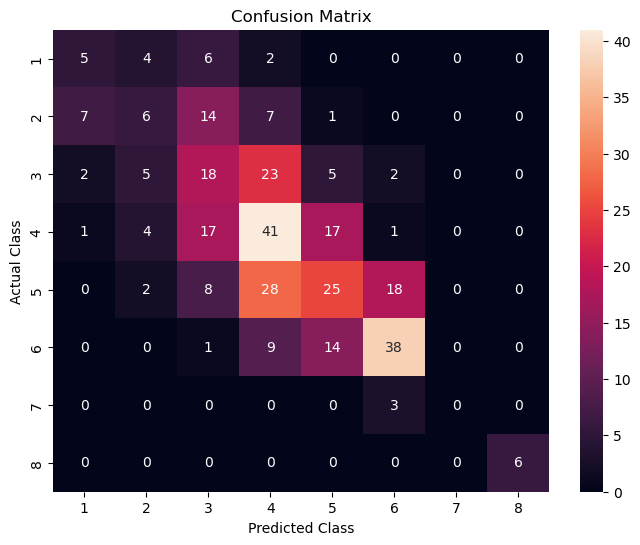

In [14]:
y_pred = best_model.predict(X_test)
print('Accuracy Score: %.3f' % best_model.score(X_test, y_test))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=range(1, 9), index=range(1, 9))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [15]:
df_recall = pd.DataFrame({'LeagueIndex': range(1, 9), 
                          'NumSampleInTrain': df_train['LeagueIndex'].value_counts().sort_index().values, 
                          'Recall': recall_score(y_test, y_pred, average=None).round(3)})
df_recall

,LeagueIndex,NumSampleInTrain,Recall
0,1,150,0.294
1,2,312,0.171
2,3,498,0.327
3,4,730,0.506
4,5,725,0.309
5,6,559,0.613
6,7,32,0.000
7,8,49,1.000


In conclusion, I think that we can use this model to predict player's rank, but I need to improve it by obtaining additional data.

## 5. Room for Improvement<a class="anchor" id="room-improvement"></a>

If I can ask advice to my collegue and obtain more data, I will ask/confirm:
* why "?" appears in three columns (Age, HoursPerWeek, TotalHours), especially of players with LeagueIndex=8.
* whether I can get more sample so that we will have samples for each LeagueIndex at the same amount.

Once I can clarify them, I will be able to:
* use three columns with confidence to build a model.
* build more accurate model because the variance of each feature variable will decrease as the number of sample increases.